# Projet

In [42]:
from scipy.fft import fft
import numpy as np
import matplotlib.pyplot as plt

import glob
import torch 
import librosa
from os import listdir
import re
import audioread

import glob
import re
import librosa
import numpy as np


In [43]:
dict_classes = {
    0: 'portuguese',
    1: 'china',
    2: 'french',
    3: 'quebec',
    4: 'maroc',
    5: 'japon',
    6: 'american',
    7: 'english',
    8: 'korean',
    9: 'spain',
    10: 'italy',
    11: 'tunis'
    }

dict_classes_inv = {
    'portuguese': 0,
    'china': 1,
    'french': 2,
    'quebec': 3,
    'maroc': 4,
    'japon': 5,
    'american': 6,
    'english': 7,
    'korean': 8,
    'spain': 9,
    'italy': 10,
    'tunis': 11
    }
list_genres = ['M', 'F']

### Datasets

In [225]:
from torch.utils.data import Dataset, DataLoader


class AudioDataset(Dataset):
    def __init__(self, mode, transform=None):

        self.names = []
        self.transform = transform
        self.mode = mode
        
        for file in glob.glob(f'spectrograms_clips/*.npy'):
            number = int(file.split('.')[0].split('_')[-1])
            if mode == "train":
                if number <= 40:
                    self.names.append(file)
            elif mode == "validation":
                if 41 <= number <= 45:
                    self.names.append(file)
            elif mode == "test":
                if 46 <= number:
                    self.names.append(file)


    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, idx):
        data = np.load(self.names[idx]).astype(np.float32)

        langue = self.names[idx].split('/')[-1].split('.')[0].split('_')[0]
        labels = dict_classes_inv[langue]

        if self.transform:
            if self.transform:
                data = transforms.ToPILImage()(data)
                # data = Image.fromarray(data)
                # data = Image.fromarray(data).convert("L")
                data = self.transform(data)
        
        return data, torch.tensor(labels, dtype=torch.long)

In [260]:
# ajouter des transformations sur les images
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



In [261]:
train_dataset = AudioDataset(mode='train', transform=transform)
val_dataset = AudioDataset(mode='validation', transform=test_transform)
test_dataset = AudioDataset(mode='test', transform=test_transform)

In [232]:
print(f"Taille du dataset d'entraînement : {len(train_dataset)}")
print(f"Taille du dataset de validation : {len(val_dataset)}")
print(f"Taille du dataset de test : {len(test_dataset)}")

Taille du dataset d'entraînement : 960
Taille du dataset de validation : 120
Taille du dataset de test : 120


torch.Size([1, 257, 345])
tensor(1)


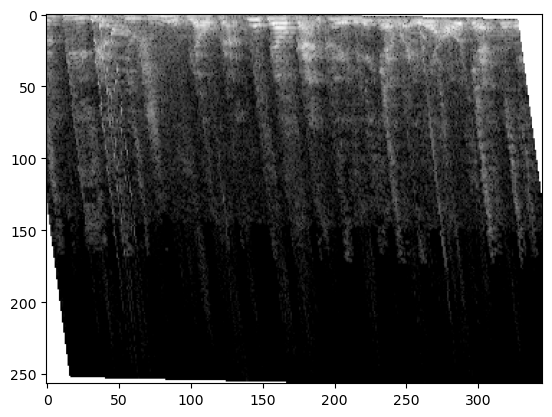

In [270]:
# afficher un exemple
data, label = train_dataset.__getitem__(0)
# afficher PIL image
print(data.shape)
print(label)
plt.imshow(data[0], cmap='gray')
plt.show()



In [120]:
# # afficher un exemple de données de train
# data, label = train_dataset.__getitem__(0)
# plt.figure(figsize=(10, 4))
# plt.imshow(data, aspect='auto', origin='lower')
# plt.colorbar(format='%+2.0f dB')
# plt.title("Spectrogram")
# plt.ylabel("Frequency")
# plt.show()

# spectro_shape = data.shape
# print(f"Shape of the spectrogram : {spectro_shape}")

In [271]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=1, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=4)

### Entrainement

##### Modèle

On va utiliser un modèle LeNet

In [333]:
# modèle LeNet
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self, num_channels, num_classes):
        super(LeNet, self).__init__()
        self.num_channels = num_channels
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(self.num_channels, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1_input_size = self._calculate_fc1_input_size()

        self.fc1 = nn.Linear(self.fc1_input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, self.num_classes)

    def _calculate_fc1_input_size(self):
        x = torch.randn(1, self.num_channels, 257, 345)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        return x.numel() # Total number of elements in the tensor

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.fc1_input_size)
        x = F.relu(self.fc1(x))
        # dropout
        x = nn.Dropout(0.2)(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#model summary
from torchsummary import summary
print((spectro_shape[0], spectro_shape[1]))
model = LeNet(num_channels=1, num_classes=12)
print(summary(model, (1, spectro_shape[0], spectro_shape[1])))

(257, 345)
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 257, 345]         156
├─Conv2d: 1-2                            [-1, 16, 124, 168]        2,416
├─Linear: 1-3                            [-1, 120]                 9,999,480
├─Linear: 1-4                            [-1, 84]                  10,164
├─Linear: 1-5                            [-1, 12]                  1,020
Total params: 10,013,236
Trainable params: 10,013,236
Non-trainable params: 0
Total mult-adds (M): 73.31
Input size (MB): 0.34
Forward/backward pass size (MB): 6.60
Params size (MB): 38.20
Estimated Total Size (MB): 45.14
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 6, 257, 345]         156
├─Conv2d: 1-2                            [-1, 16, 124, 168]        2,416
├─Linear: 1-3                            [-1, 120]                 9,999,480
├─Linear: 1-4               

In [332]:
import torch
import torch.nn as nn
from torchvision import models

# Charger le modèle ResNet18 pré-entraîné
base_model = models.resnet18(pretrained=True)
base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
# Congeler les couches du modèle de base
for param in base_model.parameters():
    param.requires_grad = False

# Modifier le modèle pour personnaliser les couches de sortie
# Remplacer le classificateur (fc) final
class CustomResNet18(nn.Module):
    def __init__(self):
        super().__init__()
        # Réutiliser le modèle de base sans la couche fully connected (fc)
        self.base = nn.Sequential(*list(base_model.children())[:-1])
        # Ajouter des couches personnalisées après la couche globale d'agrégation
        self.custom_layers = nn.Sequential(
            nn.Flatten(),  # Aplatir les dimensions après le pooling
            nn.Linear(base_model.fc.in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 12)
        )

    def forward(self, x):
        x = self.base(x)
        x = self.custom_layers(x)
        return x

# Initialiser le modèle
model = CustomResNet18()

# Vérifier la structure du modèle
print(summary(model, (1, spectro_shape[0], spectro_shape[1])))


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 1, 1]           --
|    └─Conv2d: 2-1                       [-1, 64, 129, 173]        (3,136)
|    └─BatchNorm2d: 2-2                  [-1, 64, 129, 173]        (128)
|    └─ReLU: 2-3                         [-1, 64, 129, 173]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 65, 87]          --
|    └─Sequential: 2-5                   [-1, 64, 65, 87]          --
|    |    └─BasicBlock: 3-1              [-1, 64, 65, 87]          (73,984)
|    |    └─BasicBlock: 3-2              [-1, 64, 65, 87]          (73,984)
|    └─Sequential: 2-6                   [-1, 128, 33, 44]         --
|    |    └─BasicBlock: 3-3              [-1, 128, 33, 44]         (230,144)
|    |    └─BasicBlock: 3-4              [-1, 128, 33, 44]         (295,424)
|    └─Sequential: 2-7                   [-1, 256, 17, 22]         --
|    |    └─BasicBlock: 3-5              [-1, 256, 

In [341]:
import torch
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)


# adapt the model to the input shape and output shape
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, 12)
print(summary(model, (1, spectro_shape[0], spectro_shape[1])))

Using cache found in /home/n7student/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 129, 173]        3,136
├─BatchNorm2d: 1-2                       [-1, 64, 129, 173]        128
├─ReLU: 1-3                              [-1, 64, 129, 173]        --
├─MaxPool2d: 1-4                         [-1, 64, 65, 87]          --
├─Sequential: 1-5                        [-1, 64, 65, 87]          --
|    └─BasicBlock: 2-1                   [-1, 64, 65, 87]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 65, 87]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 65, 87]          128
|    |    └─ReLU: 3-3                    [-1, 64, 65, 87]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 65, 87]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 65, 87]          128
|    |    └─ReLU: 3-6                    [-1, 64, 65, 87]          --
|    └─BasicBlock: 2-2                   [-1, 64, 65, 87]          --
|

In [342]:
from tqdm import tqdm

nb_epochs = 20

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)

#cosine annealing learning rate
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nb_epochs)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(nb_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for data, labels in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{nb_epochs}"):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(data.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_losses.append(train_loss / len(train_dataloader))
    train_accuracies.append(100 * correct / total)

    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in tqdm(val_dataloader, desc=f"Validation {epoch+1}/{nb_epochs}"):
            data, labels = data.to(device), labels.to(device)
            outputs = model(data.float())
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_losses.append(val_loss / len(val_dataloader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{nb_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")

    scheduler.step(val_losses[-1])

Validation 1/20: 100%|██████████| 120/120 [00:05<00:00, 21.71it/s]


Epoch 1/20, Train Loss: 2.5131, Train Accuracy: 7.92%, Val Loss: 2.4914, Val Accuracy: 8.33%


Validation 2/20: 100%|██████████| 120/120 [00:05<00:00, 21.70it/s]


Epoch 2/20, Train Loss: 2.4879, Train Accuracy: 8.54%, Val Loss: 2.4896, Val Accuracy: 9.17%


Validation 3/20: 100%|██████████| 120/120 [00:05<00:00, 21.03it/s]


Epoch 3/20, Train Loss: 2.4798, Train Accuracy: 9.48%, Val Loss: 2.4945, Val Accuracy: 10.83%


Validation 4/20: 100%|██████████| 120/120 [00:05<00:00, 20.99it/s]


Epoch 4/20, Train Loss: 2.4652, Train Accuracy: 11.88%, Val Loss: 2.4950, Val Accuracy: 9.17%


Epoch 5/20:  22%|██▏       | 214/960 [00:43<02:46,  4.48it/s]

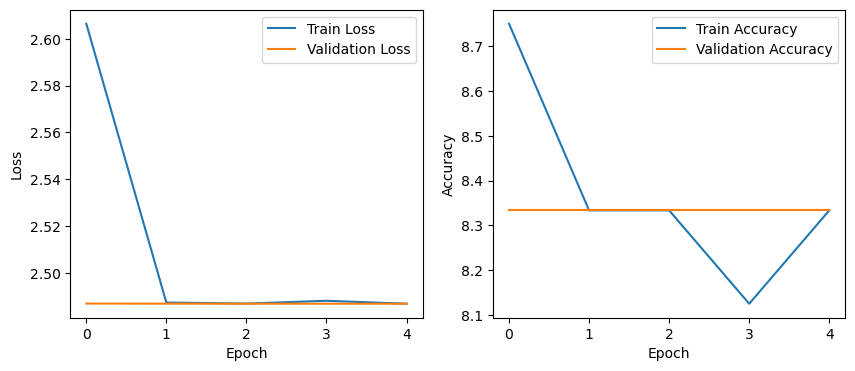

In [336]:
# plot loss and accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Test: 100%|██████████| 120/120 [00:01<00:00, 72.65it/s]


[5, 1, 5, 7, 10, 0, 6, 3, 5, 6, 0, 10, 1, 8, 10, 3, 3, 2, 4, 8, 10, 6, 8, 6, 11, 3, 11, 9, 8, 1, 2, 4, 8, 3, 8, 9, 4, 9, 7, 2, 3, 3, 11, 4, 11, 6, 7, 5, 4, 11, 6, 9, 0, 6, 4, 10, 7, 1, 0, 7, 4, 1, 5, 11, 5, 0, 2, 2, 8, 11, 4, 2, 1, 7, 5, 7, 2, 3, 8, 7, 10, 6, 1, 7, 10, 11, 9, 1, 7, 0, 11, 9, 11, 10, 0, 6, 10, 3, 5, 9, 2, 0, 8, 1, 2, 5, 1, 3, 0, 9, 9, 5, 6, 10, 4, 9, 8, 0, 4, 2]


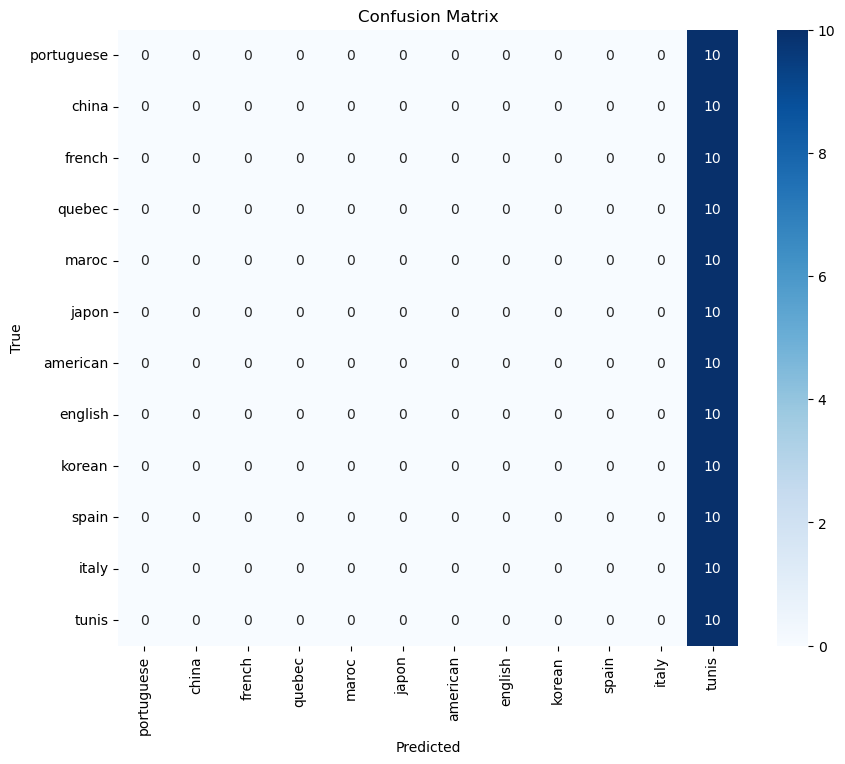

In [337]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for data, labels in tqdm(test_dataloader, desc="Test"):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data.float())
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
print(y_true)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dict_classes.values(), yticklabels=dict_classes.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
